# Modèle de langue neuronal

15 décembre 2025

Adapté du tutoriel d'A. Karphathy "Makemore", deuxième partie: https://www.youtube.com/watch?v=PaCmpygFfXo

## Jeu de données: les mots du code civil

In [2]:
words = open('civil_mots.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
nb_chars = len(chars) + 1  # On ajoute 1 pour EOS
ctoi = {c:i+1 for i,c in enumerate(chars)}
ctoi['.'] = 0
print("CTOI =", ctoi)
# Dictionnaire permettant permettant de passer d'un entier à son caractère
itoc = {i:s for s,i in ctoi.items()}
print("ITOC =", itoc)

CTOI = {"'": 1, '-': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27, 'à': 28, 'â': 29, 'ç': 30, 'è': 31, 'é': 32, 'ê': 33, 'ë': 34, 'î': 35, 'ï': 36, 'ô': 37, 'ù': 38, 'û': 39, 'œ': 40, '.': 0}
ITOC = {1: "'", 2: '-', 3: 'a', 4: 'b', 5: 'c', 6: 'd', 7: 'e', 8: 'f', 9: 'g', 10: 'h', 11: 'i', 12: 'j', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 28: 'à', 29: 'â', 30: 'ç', 31: 'è', 32: 'é', 33: 'ê', 34: 'ë', 35: 'î', 36: 'ï', 37: 'ô', 38: 'ù', 39: 'û', 40: 'œ', 0: '.'}


## Approche par réseau de neurones reproduisant l'approche par comptage

### Représentation des mots avec des vecteurs "one-hot": exemple avec un seul mot

In [3]:
import torch

# Création d'un jeu d'entrainement de bigrams (x,y)
xs, ys = [], []

for w in [words[40]]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = ctoi[ch1]
    ix2 = ctoi[ch2]
    print(ch1, ch2, '->', ix1, ix2)
    xs.append(ix1)
    ys.append(ix2)
    
xs = torch.tensor(xs)
ys = torch.tensor(ys)
print(words[40])
tensor_dims = len(words[40]) + 1
print("tensor_dims =", tensor_dims)

. a -> 0 3
a c -> 3 5
c c -> 5 5
c e -> 5 7
e p -> 7 17
p t -> 17 21
t é -> 21 32
é e -> 32 7
e . -> 7 0
acceptée
tensor_dims = 9


In [4]:
xs

tensor([ 0,  3,  5,  5,  7, 17, 21, 32,  7])

In [5]:
ys

tensor([ 3,  5,  5,  7, 17, 21, 32,  7,  0])

In [6]:
# Représentation de chaque caractère par un vecteur one-hot
# seul une composante est à 1.0, correspondant à l'indice du numéro du caractère
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=nb_chars).float()
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.,

In [7]:
# La première dimension est la dimension du tenseur exemple
xenc.shape

torch.Size([9, 41])

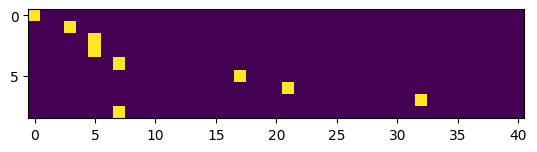

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(xenc)

In [9]:
# Pour notre réseau, on va utiliser une matrice W des valeurs normales aléatoires comme
# point de départ
W = torch.randn((nb_chars, tensor_dims))  # Quand on aura tous les mots, on utilisera nb_chars x nb_chars
W

tensor([[ 9.1839e-01, -1.1502e+00, -8.3629e-01,  1.5226e+00,  8.4343e-01,
          3.7099e-01,  1.8180e+00, -6.9873e-01,  1.1443e+00],
        [-8.5412e-01,  9.1880e-01,  1.6299e+00, -9.2986e-02,  4.3231e-01,
          3.4169e-01,  6.3554e-01, -2.3884e+00, -1.6909e-01],
        [ 1.1750e+00,  9.7545e-01,  6.1806e-01,  2.2869e-01, -1.2293e+00,
          8.1735e-01, -9.5131e-01,  1.2416e+00,  5.6462e-01],
        [ 2.6404e-01, -1.0920e-01,  5.7622e-01,  1.4399e-01,  7.6392e-01,
          3.0535e-01, -7.3563e-01, -9.6206e-01,  3.5338e-01],
        [ 1.5070e+00,  1.4913e+00,  2.9527e-01, -4.1975e-01, -1.4888e+00,
          6.9776e-01,  8.9753e-01,  1.0222e+00, -1.4788e+00],
        [ 1.2613e-01,  8.5963e-01, -7.1895e-01, -2.6217e+00,  4.3825e-01,
          2.3034e+00, -1.7862e+00,  3.5024e-01,  9.5713e-01],
        [-3.4914e-01,  1.1381e+00, -8.4526e-01,  3.8407e-01, -2.9689e-02,
         -8.9423e-01,  9.8505e-01,  9.0442e-01, -5.1849e-01],
        [ 6.5824e-01, -7.6243e-01, -8.5083e-02, 

In [10]:
# En multipliant ces "poids" par nos vecteurs one-hot organisés en matrice...
# On obtient des valeurs que l'on va "interpréter" comme des logs (log-counts).
# En utilisant l'exponentielle de ces valeurs, on va retrouver quelque chose
# d'équivalent à la matrice N que nous avions définie précédemment dans la méthode
# par comptage.
xenc @ W

tensor([[ 0.9184, -1.1502, -0.8363,  1.5226,  0.8434,  0.3710,  1.8180, -0.6987,
          1.1443],
        [ 0.2640, -0.1092,  0.5762,  0.1440,  0.7639,  0.3053, -0.7356, -0.9621,
          0.3534],
        [ 0.1261,  0.8596, -0.7190, -2.6217,  0.4382,  2.3034, -1.7862,  0.3502,
          0.9571],
        [ 0.1261,  0.8596, -0.7190, -2.6217,  0.4382,  2.3034, -1.7862,  0.3502,
          0.9571],
        [ 0.6582, -0.7624, -0.0851, -1.5097,  0.3336, -0.0473, -0.5248,  1.1375,
         -0.3833],
        [ 1.1454, -0.4368,  2.2854,  1.1893,  0.4097, -0.1171, -0.0219, -0.8455,
          0.1224],
        [ 0.1107,  1.1431,  2.0399, -0.5574,  0.6768, -0.6810, -0.8757, -1.2483,
          0.7762],
        [ 1.1026, -0.8772,  1.5426,  0.4497,  0.3101,  0.9702,  0.7891,  1.0092,
          2.0941],
        [ 0.6582, -0.7624, -0.0851, -1.5097,  0.3336, -0.0473, -0.5248,  1.1375,
         -0.3833]])

In [11]:
logits = xenc @ W # log-counts 
counts = logits.exp() # statut équivalent à N
probs = counts / counts.sum(1, keepdims=True) # distribution de probabilités (equ. à p)
probs

tensor([[0.1170, 0.0148, 0.0202, 0.2141, 0.1086, 0.0677, 0.2877, 0.0232, 0.1467],
        [0.1192, 0.0821, 0.1629, 0.1057, 0.1965, 0.1243, 0.0439, 0.0350, 0.1304],
        [0.0573, 0.1193, 0.0246, 0.0037, 0.0783, 0.5053, 0.0085, 0.0717, 0.1315],
        [0.0573, 0.1193, 0.0246, 0.0037, 0.0783, 0.5053, 0.0085, 0.0717, 0.1315],
        [0.1879, 0.0454, 0.0893, 0.0215, 0.1358, 0.0928, 0.0576, 0.3034, 0.0663],
        [0.1439, 0.0296, 0.4501, 0.1504, 0.0690, 0.0407, 0.0448, 0.0197, 0.0518],
        [0.0625, 0.1756, 0.4304, 0.0321, 0.1101, 0.0283, 0.0233, 0.0161, 0.1216],
        [0.1126, 0.0156, 0.1749, 0.0586, 0.0510, 0.0987, 0.0823, 0.1026, 0.3036],
        [0.1879, 0.0454, 0.0893, 0.0215, 0.1358, 0.0928, 0.0576, 0.3034, 0.0663]])

#### Réseau de neurones sur cet exemple

In [12]:
# Initialisation de "nb_chars" poids de neurones
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((nb_chars, nb_chars), generator=g, requires_grad=True)

In [13]:
# Réseau à une couche (probs)
xenc = F.one_hot(xs, num_classes=nb_chars).float() # input to the network: one-hot encoding
logits = xenc @ W  # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True)  # probabilities for next character
# btw: the last 2 lines here are together called a 'softmax'

In [14]:
nlls = torch.zeros(5)
for i in range(5):
    # i-th bigram:
    x = xs[i].item() # input character index
    y = ys[i].item() # label character index
    print('--------')
    print(f'bigram example {i+1}: {itoc[x]}{itoc[y]} (indexes {x},{y})')
    print('input to the neural net:', x)
    print('output probabilities from the neural net:', probs[i])
    print('label (actual next character):', y)
    p = probs[i, y]
    print('probability assigned by the net to the the correct character:', p.item())
    logp = torch.log(p)
    print('log likelihood:', logp.item())
    nll = -logp
    print('negative log likelihood:', nll.item())
    nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

--------
bigram example 1: .a (indexes 0,3)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0495, 0.0081, 0.0100, 0.0034, 0.0137, 0.0100, 0.0022, 0.0189, 0.0112,
        0.0255, 0.0064, 0.0227, 0.0074, 0.0067, 0.0407, 0.1939, 0.0492, 0.0020,
        0.0203, 0.0045, 0.0276, 0.0089, 0.0023, 0.0162, 0.0096, 0.1253, 0.1189,
        0.0053, 0.0030, 0.0140, 0.0035, 0.0214, 0.0109, 0.0382, 0.0046, 0.0044,
        0.0017, 0.0361, 0.0030, 0.0348, 0.0039], grad_fn=<SelectBackward0>)
label (actual next character): 3
probability assigned by the net to the the correct character: 0.003431369084864855
log likelihood: -5.674796104431152
negative log likelihood: 5.674796104431152
--------
bigram example 2: ac (indexes 3,5)
input to the neural net: 3
output probabilities from the neural net: tensor([0.0017, 0.0064, 0.0258, 0.0032, 0.0085, 0.0247, 0.0371, 0.0103, 0.0104,
        0.0024, 0.0027, 0.0207, 0.0226, 0.0620, 0.0193, 0.0406, 0.1549, 0.0225,
        0.0073, 0.0261, 

#### Optimization sur un mot

In [36]:
# forward pass
xenc = F.one_hot(xs, num_classes=nb_chars).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
loss = -probs[torch.arange(tensor_dims), ys].log().mean()

In [37]:
print(loss.item())

3.725316047668457


In [38]:
# backward pass
W.grad = None # set to zero the gradient
loss.backward()

In [39]:
W.data += -0.1 * W.grad
# ^^ loop above from forward pass and see loss decreasing

### Synthèse: apprentissage complet

In [40]:
#
# Générateur des mots selon notre modèle de langue génératif bigrams par réseau de neurones
#
import torch

# Lecture des données
EOS='.'
words = open('civil_mots.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
nb_chars = len(chars) + 1  # On ajoute 1 pour EOS

# Dictionnaires caractère <-> entier
ctoi = {c:i+1 for i,c in enumerate(chars)}
ctoi['.'] = 0
itoc = {i:c for c,i in ctoi.items()}# Création du dataset avec tous les mots

# Génération du jeu d'entraînement
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = ctoi[ch1]
        ix2 = ctoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('NB exemples:', num)

# Initialisation du réseau (une seule couche de neurones sans biais)
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((nb_chars, nb_chars), generator=g, requires_grad=True)

NB exemples: 67652


In [41]:
# Apprentissage: descente du gradient
for k in range(600):
  
  # Forward pass
  xenc = F.one_hot(xs, num_classes=nb_chars).float() # input to the network: one-hot encoding
  logits = xenc @ W # predict log-counts (logits)
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()  # + 0.01... for smoothing the model
  print(loss.item())
  
  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()
  
  # update
  W.data += -50 * W.grad

4.268752574920654
3.8354008197784424
3.5137295722961426
3.2882258892059326
3.136672258377075
3.0282742977142334
2.9461023807525635
2.881960153579712
2.830700159072876
2.788752555847168
2.75366473197937
2.723792552947998
2.69801926612854
2.6755597591400146
2.6558377742767334
2.6384148597717285
2.622948169708252
2.609158754348755
2.5968127250671387
2.585711717605591
2.575685501098633
2.566587209701538
2.5582938194274902
2.5506985187530518
2.543713331222534
2.537261962890625
2.5312814712524414
2.5257174968719482
2.5205249786376953
2.5156655311584473
2.5111048221588135
2.5068154335021973
2.5027718544006348
2.498953342437744
2.495340585708618
2.491917610168457
2.4886693954467773
2.4855830669403076
2.482647657394409
2.4798519611358643
2.477186679840088
2.4746437072753906
2.472215175628662
2.4698939323425293
2.4676730632781982
2.4655468463897705
2.463510274887085
2.461557626724243
2.459684371948242
2.457886219024658
2.4561588764190674
2.454498529434204
2.452902317047119
2.4513659477233887
2.4

In [42]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  
  out = []
  ix = 0
  while True:
    
    # ----------
    # Avec l'approche par comptage on utilisait:
    #p = P[ix]
    # ----------
    # NOW:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=nb_chars).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------
    
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itoc[ix])
    if ix == 0:
      break
  print(''.join(out))

éssanée.
mexcororér.
monts.
ex.
moût.


On voit qu'on a les mêmes mots que ceux générés par comptage, nous avons donc bâti une méthode neuronale équivalente à ce qu'on obtient par la méthode par comptage.